# Poisson Regression

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson as pois
import time
from copy import deepcopy
import pandas as pd
from sklearn.model_selection import train_test_split as split

In [31]:
def f_poisson(T,a,b):
    '''
    T is the weight vector in R^n, a is the regressor matrix in R^{n x m}, b is the count data in R^m
    '''
    u = a.T @ T
    return np.sum(np.exp(u)) - np.dot(y,u)
def g_poisson(T,a,b):
    '''
    T is the weight vector in R^n, a is the regressor matrix in R^{n x m}, b is the count data in R^m
    '''
    u = np.exp( a.T @ T )
    return a @ u - b@a.T
def GD_poisson(T,a,b,LAMBDA):
    '''Perform Steepest Gradient Descent'''
    return T - LAMBDA*g_poisson(T,a,b)
def ren(x): return range(len(x))
rng = np.random.default_rng()

In [139]:
N = 10
M = 20000

In [140]:
omega = rng.random(N +1)
X = rng.random((N,M))
x = np.concatenate((np.ones((1,M)),X),axis = 0)
lamb = np.exp(x.T @ omega)
y = np.array([pois.rvs(i) for i in lamb])
th = rng.random(len(x))

## Vanilla

In [141]:
ERROR = 1e-6

In [178]:
initialTime = time.time()
weights = deepcopy(th)
# lam = 1
lam = np.max( np.linalg.svd( x @ x.T )[1] )
grad = g_poisson(weights,x,y)
gradNorm = np.linalg.norm(grad)
# print(gradNorm)
gradientValueList = [gradNorm]
functionVals = [f_poisson(weights,x,y)]
timeList = [time.time() - initialTime]
while gradNorm > ERROR:
    weights = GD_poisson(weights,x,y,lam)
    grad = g_poisson(weights,x,y)
    gradNorm = np.linalg.norm(grad)
#     print(gradNorm)
    gradientValueList.append(gradNorm)
    functionVals.append(f_poisson(weights,x,y))
    timeList.append(time.time()-initialTime)
    if gradientValueList[-1] >= gradientValueList[-2]:
        print('ping! Iteration:', len(gradientValueList))
        weights = deepcopy(th)
        lam = 0.1*lam
        grad = g_poisson(weights,x,y)
        gradNorm = np.linalg.norm(grad)
        gradientValueList.append(gradNorm)
        functionVals.append(f_poisson(weights,x,y))
        timeList.append(time.time()-initialTime)

ping! Iteration: 2
ping! Iteration: 4
ping! Iteration: 6
ping! Iteration: 8
ping! Iteration: 10
ping! Iteration: 12
ping! Iteration: 14
ping! Iteration: 16
ping! Iteration: 18
ping! Iteration: 20
ping! Iteration: 22


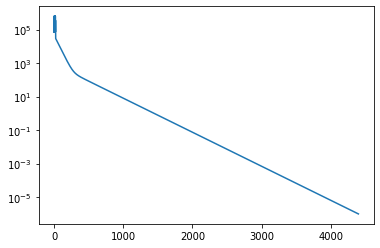

In [179]:
plt.plot(ren(gradientValueList), gradientValueList)
plt.yscale('log')
plt.show()

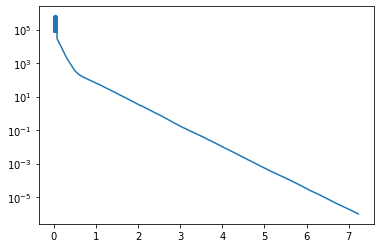

In [180]:
plt.plot(timeList, gradientValueList)
plt.yscale('log')
plt.show()

In [181]:
lam

7.130113480847342e-07

## Adaptive

In [182]:
initialTime = time.time()
weights = deepcopy(th)
lam = lam = 1/np.max(np.linalg.svd(x @ x.T)[1]*M*N)
theta = np.inf
weights0 = deepcopy(weights)
grad = g_poisson(weights,x,y)
gradNorm = np.linalg.norm(grad)
gradientValueList = [gradNorm]
functionVals = [f_poisson(weights,x,y)]
timeList = [time.time() - initialTime]

weights = GD_poisson(weights,x,y,lam)
oldGrad = deepcopy(grad)
grad = g_poisson(weights,x,y)
gradNorm = np.linalg.norm(grad)
gradientValueList.append(gradNorm)
functionVals.append(f_poisson(weights,x,y))
timeList.append(time.time()-initialTime)
while gradNorm > ERROR:
    lam0 = deepcopy(lam)
    min1 = np.sqrt(1 + theta)*lam
    min2_nom = np.linalg.norm(weights - weights0)
    min2_denom = 2*np.linalg.norm(grad - oldGrad)
    lam = np.min([min1, (min2_nom/min2_denom)])
    weights0 = deepcopy(weights)
    weights = GD_poisson(weights,x,y,lam)
    theta = lam/lam0
    oldGrad = grad
    grad = g_poisson(weights,x,y)
    gradNorm = np.linalg.norm(grad)
    gradientValueList.append(gradNorm)
    functionVals.append(f_poisson(weights,x,y))
    timeList.append(time.time()-initialTime)

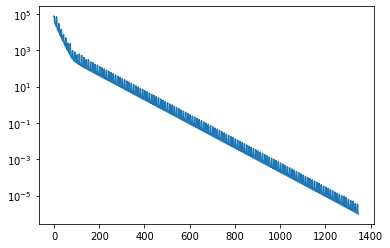

In [183]:
plt.plot(ren(gradientValueList), gradientValueList)
plt.yscale('log')
plt.show()

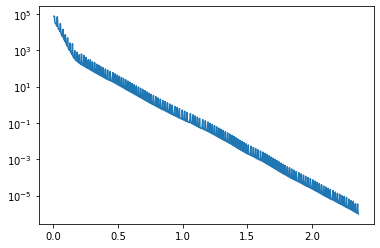

In [184]:
plt.plot(timeList, gradientValueList)
plt.yscale('log')
plt.show()

In [185]:
lam

7.196996751126927e-07

## Gradient-Based Line Search

In [186]:
def BackTrack(GRAD, GRADNORM, W, X,Y):
    rho = rng.random()
    LAM = rng.random()*10
    while 1 > (GRADNORM/np.linalg.norm( g_poisson(W - LAM*GRAD, X, Y) - GRAD ) ):
        LAM = rho*LAM
    return LAM

initialTime = time.time()
weights = deepcopy(th)
grad = g_poisson(weights,x,y)
gradNorm = np.linalg.norm(grad)
gradientValueList = [gradNorm]
functionVals = [f_poisson(weights,x,y)]
timeList = [time.time() - initialTime]
while gradNorm > ERROR:
    lam = BackTrack(grad, gradNorm, weights, x, y)
    weights = GD_poisson(weights,x,y,lam)
    grad = g_poisson(weights,x,y)
    gradNorm = np.linalg.norm(grad)
    gradientValueList.append(gradNorm)
    functionVals.append(f_poisson(weights,x,y))
    timeList.append(time.time()-initialTime)

<ipython-input-31-b405ab37e975>:11: RuntimeWarning: overflow encountered in exp
  u = np.exp( a.T @ T )


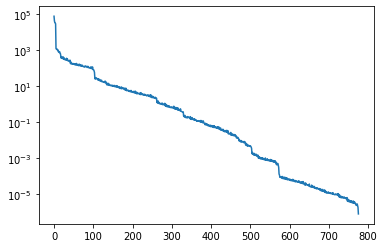

In [187]:
plt.plot(ren(gradientValueList), gradientValueList)
plt.yscale('log')
plt.show()

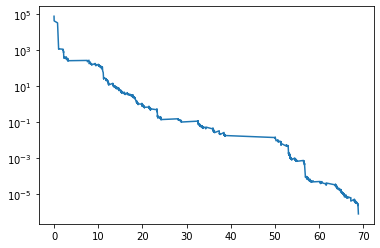

In [188]:
plt.plot(timeList, gradientValueList)
plt.yscale('log')
plt.show()

In [189]:
lam

7.825305492170115e-07

## Barzilai-Borwein

In [190]:
initialTime = time.time()
weights = deepcopy(th)
lam = 1/np.max(np.linalg.svd(x @ x.T)[1]*M*N)
weights0 = deepcopy(weights)
grad = g_poisson(weights,x,y)
gradNorm = np.linalg.norm(grad)
gradientValueList = [gradNorm]
functionVals = [f_poisson(weights,x,y)]
timeList = [time.time() - initialTime]

weights = GD_poisson(weights,x,y,lam)
oldGrad = deepcopy(grad)
grad = g_poisson(weights,x,y)
gradNorm = np.linalg.norm(grad)
gradientValueList.append(gradNorm)
functionVals.append(f_poisson(weights,x,y))
timeList.append(time.time()-initialTime)
while gradNorm > ERROR:
    nom = np.dot(weights - weights0, grad - oldGrad)
    denom = np.linalg.norm(grad - oldGrad)**2
    lam = nom/denom
    weights0 = deepcopy(weights)
    weights = GD_poisson(weights,x,y,lam)
    oldGrad = deepcopy(grad)
    grad = g_poisson(weights,x,y)
    gradNorm = np.linalg.norm(grad)
    gradientValueList.append(gradNorm)
    functionVals.append(f_poisson(weights,x,y))
    timeList.append(time.time()-initialTime)

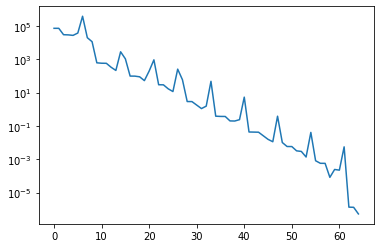

In [191]:
plt.plot(ren(gradientValueList), gradientValueList)
plt.yscale('log')
plt.show()

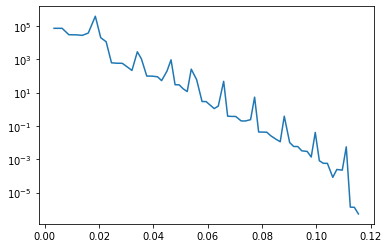

In [192]:
plt.plot(timeList, gradientValueList)
plt.yscale('log')
plt.show()

In [193]:
lam

2.372988118888691e-05

## Nesterov

In [194]:
initialTime = time.time()
weights = deepcopy(th)
L = np.max( np.linalg.svd( x @ x.T )[1] )
# L = 10
grad = g_poisson(weights,x,y)
gradNorm = np.linalg.norm(grad)
# print(gradNorm)
gradientValueList = [gradNorm]
functionVals = [f_poisson(weights,x,y)]
timeList = [time.time() - initialTime]
lam1 = 1
y0 = weights
while gradNorm > ERROR:
    lam = 0.5*(1 + np.sqrt(1 + 4*lam1**2))
    gamma = (1 - lam1)/lam
    y1 = weights - grad/L
    weights = (1 - gamma)*y1 + gamma*y0
    lam1 = lam
    y0 = y1
    grad = g_poisson(weights,x,y)
    gradNorm = np.linalg.norm(grad)
#     print(gradNorm)
    gradientValueList.append(gradNorm)
    functionVals.append(f_poisson(weights,x,y))
    timeList.append(time.time()-initialTime)
    if gradientValueList[-1] == gradientValueList[-2]:
        print('ping! Iteration:', len(gradientValueList))
        weights = deepcopy(th)
        L = L*10
        grad = g_poisson(weights,x,y)
        gradNorm = np.linalg.norm(grad)
        gradientValueList.append(gradNorm)
        functionVals.append(f_poisson(weights,x,y))
        timeList.append(time.time()-initialTime)
        lam1 = 1
        y0 = weights

ping! Iteration: 5
ping! Iteration: 53


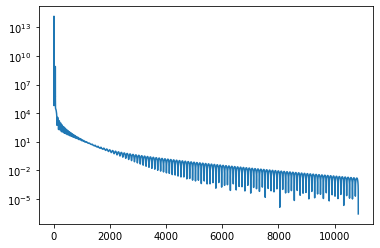

In [195]:
plt.plot(ren(gradientValueList), gradientValueList)
plt.yscale('log')
plt.show()

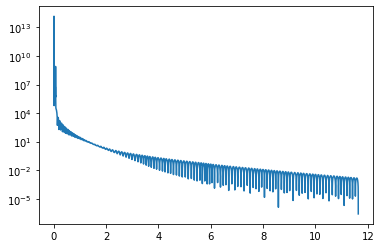

In [196]:
plt.plot(timeList, gradientValueList)
plt.yscale('log')
plt.show()

In [199]:
1/L

1.4025022219999233e-07